In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random

In [2]:
data_full = pd.read_csv("nba_player_stats_20250304.csv")

data_full.head()

,SEASON_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,...,FTA_PER_GAME,OREB_PER_GAME,DREB_PER_GAME,REB_PER_GAME,AST_PER_GAME,STL_PER_GAME,BLK_PER_GAME,TOV_PER_GAME,PF_PER_GAME,PTS_PER_GAME
0,1985-86,LAL,22.0,82,1.0,1542.0,209,388,0.539,1.0,...,2.04,1.95,2.70,4.65,0.66,0.60,0.60,1.21,2.79,6.35
1,1986-87,LAL,23.0,79,72.0,2240.0,316,587,0.538,0.0,...,3.57,2.66,5.13,7.78,1.06,0.89,1.01,1.29,2.16,10.78
2,1987-88,LAL,24.0,82,64.0,2636.0,322,640,0.503,0.0,...,4.62,2.99,5.67,8.66,1.13,1.06,0.55,1.46,2.49,11.43
3,1988-89,LAL,25.0,82,82.0,2510.0,401,758,0.529,4.0,...,4.38,3.15,5.87,9.01,1.26,1.15,0.67,1.45,2.10,13.27
4,1989-90,LAL,26.0,82,82.0,2709.0,385,806,0.478,13.0,...,4.51,3.20,5.49,8.68,1.10,0.80,0.61,1.41,2.52,12.94


In [3]:
def check_for_nans(data):
    """
    Check for NaNs in the dataset.
    """
    if data.isna().any().any():
        print("NaNs found in the data")
    else:
        print("No NaNs found in the data")

check_for_nans(data_full)

NaNs found in the data


In [4]:
def print_rows_with_nans(df):
    """
    Prints out all rows in the DataFrame that contain NaNs along with the unique columns.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to check for NaNs.
    """
    rows_with_nans = df[df.isna().any(axis=1)]
    nan_columns = rows_with_nans.columns[rows_with_nans.isna().any()].tolist()
    print(f"Columns with NaNs: {nan_columns}")

print_rows_with_nans(data_full)

Columns with NaNs: ['GS', 'FG_PCT', 'FG3_PCT', 'FT_PCT']


In [5]:
# for players traded mid-season, the data has multiple rows containing information for each team they played for. 
# this breaks the year-by-year sequential structure i want.
data_full["is_traded"] = data_full.duplicated(subset=["SEASON_ID", "PLAYER_NAME"], keep=False).astype(int) 
# creating a new column to represent seasons where the player was traded
data_full = data_full[(data_full["TEAM_ABBREVIATION"] == "TOT") | (data_full["is_traded"] == 0)] # dropping all non "TOT" rows for traded players.

In [6]:
data_full = data_full.drop(columns=['GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS']) # these are season totals, i need per game values

# Since FG%, GS, FG3%, FT% have nan values I will drop them. They either have redundant data or meaningless data in the case of GS (IMO).
# I will add a masking layer so that they don't interfere with the model.
# A cleaner solution would be to drop the columns or remove old data but I'll do it this way since there's already so little data.

In [7]:
data_full = data_full.drop(columns=["TEAM_ABBREVIATION", "SEASON_ID"]) # dropping the unnecessary columns except season_start_year and player_name
# we'll need them for sorting and grouping later on.

In [8]:
data_full = data_full.fillna(-999.0) # just in case

We need to normalize the data but we cant do it normally since there are masked values of -999.0.

In [9]:
data = data_full[data_full["SEASON_START_YEAR"] != 2025] # since the 2024-2025 season isnt complete, it shouldnt be used in training

In [10]:
def compute_normalization_params(df, mask_value=-999.0):
    """
    Compute per-column means and stds ignoring the masked value.
    """
    
    columns = df.select_dtypes(include=[np.number]).columns.tolist()
        
    means = {}
    stds = {}
    for col in columns:
        # need to filter out the masked values before computing the statistics
        valid_data = df.loc[df[col] != mask_value, col]
        means[col] = valid_data.mean()
        stds[col] = valid_data.std()
    return means, stds

def normalize_data(df, means, stds, mask_value=-999.0):
    """
    Normalize data column-wise using provided means and stds while leaving masked values unchanged.
    """
    
    df_normalized = df.copy()
    columns = df.select_dtypes(include=[np.number]).columns.tolist()
        
    for col in columns:
        df_normalized[col] = df_normalized[col].astype("float64")
        valid_mask = df_normalized[col] != mask_value # normalize only valid entries
        df_normalized.loc[valid_mask, col] = (df_normalized.loc[valid_mask, col] - means[col]) / stds[col]
    return df_normalized

In [11]:
means, stds = compute_normalization_params(data_full)

data_full_normalized = normalize_data(data_full, means, stds, mask_value=-999.0)
data_normalized = normalize_data(data, means, stds, mask_value=-999.0)

In [12]:
players = data["PLAYER_NAME"].unique()
train_players, val_players = train_test_split(players, test_size=0.1, random_state=42) 
# i split before creating the sequences. if i split afterwards, i will not be able to validate on out of sample data.

train_data = data_normalized[data_normalized["PLAYER_NAME"].isin(train_players)]
val_data = data_normalized[data_normalized["PLAYER_NAME"].isin(val_players)]

In [13]:
data.columns

Index(['PLAYER_AGE', 'GP', 'SEASON_START_YEAR', 'PLAYER_NAME', 'MIN_PER_GAME',
       'FGM_PER_GAME', 'FGA_PER_GAME', 'FG3M_PER_GAME', 'FG3A_PER_GAME',
       'FTM_PER_GAME', 'FTA_PER_GAME', 'OREB_PER_GAME', 'DREB_PER_GAME',
       'REB_PER_GAME', 'AST_PER_GAME', 'STL_PER_GAME', 'BLK_PER_GAME',
       'TOV_PER_GAME', 'PF_PER_GAME', 'PTS_PER_GAME', 'is_traded'],
      dtype='object')

In [14]:
def create_sequences(data):
    """
    Create sequences for the entire career of a player.
    Each sequence grows in length and the label is the stats we're trying to predict for the following year.
    """
    sequences = []
    labels = []
    player_info = []
    player_groups = data.groupby("PLAYER_NAME")
    
    for player_name, group in player_groups:
        group = group.sort_values(by="SEASON_START_YEAR").reset_index(drop=True)
        
        for i in range(1, len(group)):
            seq = group.iloc[:i].drop(columns=["PLAYER_NAME", "SEASON_START_YEAR"]).values
            label = group.iloc[[i]].drop(columns=["PLAYER_AGE", "PLAYER_NAME", "SEASON_START_YEAR", "is_traded"]).values.flatten()
            sequences.append(seq)
            labels.append(label)
            player_info.append((player_name, group.iloc[i]["SEASON_START_YEAR"])) 
            # need to retain info to know what and whose season we're predicting later on
    
    return sequences, labels, player_info
    # the output needs to be flattened to go back to 1d label structure

In [15]:
train_sequences, train_labels, train_player_info = create_sequences(train_data)
val_sequences, val_labels, val_player_info = create_sequences(val_data)

In [16]:
train_sequences = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, dtype="float32", padding="pre", value = -999.0)
val_sequences = tf.keras.preprocessing.sequence.pad_sequences(val_sequences, dtype="float32", padding="pre", value = -999.0)

# i'm padding the sequences since they variable length sequences can cause problems in the training process.

In [17]:
train_labels = np.array(train_labels, dtype="float32")
val_labels = np.array(val_labels, dtype="float32")

# making sure the labels have the correct dtype

In [18]:
# converting to tf datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sequences, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sequences, val_labels))

In [19]:
batch_size = 32

train_dataset = train_dataset.shuffle(len(train_sequences)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [176]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Masking(mask_value= -999.0), # masking the padded parts of the sequence
    tf.keras.layers.LSTM(128, return_sequences=False, dropout=0.1, recurrent_dropout=0.05, use_bias=False),  
    tf.keras.layers.Dense(train_labels.shape[1], use_bias=False) # no bias to force the model to not learn averages but use past values for predictions
]) # i will optimize the model architecture in further iterations. so far, it seems like larger and deeper networks lead to overfitting.

# since the data by its nature is very noisy we need to be vary of overfitting to noise! 

model.compile(optimizer="Adam", loss="MSE")
model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_22 (Masking)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_45 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [166]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
# early stopping so we stop training when the model stops overfitting, and only save the best model based on out of sample estimates.

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=1, min_lr=1e-6)
# reduce_lr helps the model stop diverging if its learning rate becomes too large as it gets closer to the minimum.

In [179]:
history = model.fit(train_dataset, epochs=1000, batch_size=32, 
                    validation_data=val_dataset, callbacks=[early_stopping, reduce_lr])

Epoch 1/1000
445/445 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2797 - val_loss: 0.2909 - learning_rate: 2.2518e-05
Epoch 2/1000
445/445 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2814 - val_loss: 0.2906 - learning_rate: 2.2518e-05
Epoch 3/1000
445/445 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2878 - val_loss: 0.2907 - learning_rate: 2.2518e-05
Epoch 4/1000
445/445 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2838 - val_loss: 0.2906 - learning_rate: 1.8014e-05
Epoch 5/1000
445/445 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2868 - val_loss: 0.2906 - learning_rate: 1.4412e-05
Epoch 6/1000
445/445 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2808 - val_loss: 0.2906 - learning_rate: 1.1529e-05
Epoch 7/1000
445/445 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2835 - val_loss: 0.2906 - learning_rate: 9.2234e-06
Epoch 8/1000
445/445 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2853 - val_loss: 0.2906 - learning_rate: 7.3787e-06
Epoch 9/1000
445/445 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0

The MSE loss by itself doesn't mean much. Let's see some actual predictions to see how close we're getting!

In [180]:
stats_columns = data.drop(columns=["PLAYER_NAME", "SEASON_START_YEAR", "PLAYER_AGE", "is_traded"]).columns.tolist()

In [181]:
def inverse_normalize(normalized_preds, means, stds, columns):
    """
    Retransform normalized predictions to the original scale.
    """

    if len(normalized_preds.shape) == 1:
        original_preds = np.empty_like(normalized_preds)
        for i, col in enumerate(columns):
            original_preds[i] = normalized_preds[i] * stds[col] + means[col]
    else:
        original_preds = np.empty_like(normalized_preds)
        for i, col in enumerate(columns):
            original_preds[:, i] = normalized_preds[:, i] * stds[col] + means[col]
    
    return original_preds

Let's compare the prediction of a random season from a random player with its prediction.

In [198]:
print("\nPredictions vs Actual Values:")

num_predictions = 1
random_indices = random.sample(range(len(val_sequences)), num_predictions)

for idx in random_indices:
    seq = val_sequences[idx:idx+1]  # select the sequence
    actual = val_labels[idx]         # select the actual label
    prediction = model.predict(seq)  # make prediction
    # retransform the normalized prediction back to the original scale
    original_prediction = inverse_normalize(prediction, means, stds, stats_columns)
    original_actual = inverse_normalize(actual, means, stds, stats_columns)
    
    player_name, season_year = val_player_info[idx]  # get player info
    print(f"Player: {player_name}, Year: {season_year * stds["SEASON_START_YEAR"] + means["SEASON_START_YEAR"]:.0f}")
    print("Stats:")
    for stat, actual_val, pred_val in zip(stats_columns, original_actual, original_prediction[0]):
        print(f"  {stat}: Actual = {actual_val:.1f}, Prediction = {pred_val:.1f}")


Predictions vs Actual Values:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Player: Kenny Smith, Year: 1993
Stats:
  GP: Actual = 82.0, Prediction = 70.9
  MIN_PER_GAME: Actual = 29.5, Prediction = 30.8
  FGM_PER_GAME: Actual = 4.7, Prediction = 5.2
  FGA_PER_GAME: Actual = 9.1, Prediction = 11.2
  FG3M_PER_GAME: Actual = 1.2, Prediction = 0.6
  FG3A_PER_GAME: Actual = 2.7, Prediction = 1.8
  FTM_PER_GAME: Actual = 2.4, Prediction = 2.6
  FTA_PER_GAME: Actual = 2.7, Prediction = 3.2
  OREB_PER_GAME: Actual = 0.3, Prediction = 0.4
  DREB_PER_GAME: Actual = 1.6, Prediction = 1.7
  REB_PER_GAME: Actual = 1.9, Prediction = 2.1
  AST_PER_GAME: Actual = 5.4, Prediction = 6.4
  STL_PER_GAME: Actual = 1.0, Prediction = 1.1
  BLK_PER_GAME: Actual = 0.1, Prediction = 0.1
  TOV_PER_GAME: Actual = 2.0, Prediction = 2.4
  PF_PER_GAME: Actual = 1.3, Prediction = 1.5
  PTS_PER_GAME: Actual = 13.0, Prediction = 13.2


For someone a bit more familier, let's predict LeBron James's current and next seasons. 

(Since the current season is not finished yet and LeBron has only played a fraction of the games, the model will likely assume he was injured this season and lower his numbers aggressively.)

In [199]:
lebron_data = data_normalized[data_normalized["PLAYER_NAME"] == "LeBron James"].sort_values(by="SEASON_START_YEAR").reset_index(drop=True)
lebron_sequence = lebron_data.drop(columns=["PLAYER_NAME", "SEASON_START_YEAR"]).values
lebron_sequence_padded = tf.keras.preprocessing.sequence.pad_sequences(
                        [lebron_sequence], dtype="float32", padding="pre", value=-999.0, maxlen=train_sequences.shape[1])

prediction = model.predict(lebron_sequence_padded)

lebron_prediction_original = inverse_normalize(prediction, means, stds, stats_columns)

print(f"LeBron's Predicted Stats for the 2024-2025 Season:")
for stat, pred_val in zip(stats_columns, lebron_prediction_original[0]):
    print(f"  {stat}: {pred_val:.1f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
LeBron's Predicted Stats for the 2024-2025 Season:
  GP: 57.6
  MIN_PER_GAME: 33.3
  FGM_PER_GAME: 8.8
  FGA_PER_GAME: 17.6
  FG3M_PER_GAME: 2.1
  FG3A_PER_GAME: 5.7
  FTM_PER_GAME: 3.8
  FTA_PER_GAME: 4.9
  OREB_PER_GAME: 0.9
  DREB_PER_GAME: 6.5
  REB_PER_GAME: 7.4
  AST_PER_GAME: 7.5
  STL_PER_GAME: 1.1
  BLK_PER_GAME: 0.7
  TOV_PER_GAME: 3.1
  PF_PER_GAME: 1.3
  PTS_PER_GAME: 23.4


For reference, here are the current values (as of March 11th):
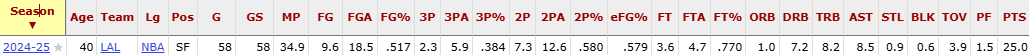

Lebron outperforming expectations as usual!

In [200]:
lebron_data = data_full_normalized[data_full_normalized["PLAYER_NAME"] == "LeBron James"].sort_values(by="SEASON_START_YEAR").reset_index(drop=True)
lebron_sequence = lebron_data.drop(columns=["PLAYER_NAME", "SEASON_START_YEAR"]).values
lebron_sequence_padded = tf.keras.preprocessing.sequence.pad_sequences(
                        [lebron_sequence], dtype="float32", padding="pre", value=-999.0, maxlen=train_sequences.shape[1])

prediction = model.predict(lebron_sequence_padded)

lebron_prediction_original = inverse_normalize(prediction, means, stds, stats_columns)

print(f"LeBron's Predicted Stats for the 2025-2026 Season:")
for stat, pred_val in zip(stats_columns, lebron_prediction_original[0]):
    print(f"  {stat}: {pred_val:.1f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
LeBron's Predicted Stats for the 2025-2026 Season:
  GP: 55.5
  MIN_PER_GAME: 33.2
  FGM_PER_GAME: 8.4
  FGA_PER_GAME: 16.9
  FG3M_PER_GAME: 2.1
  FG3A_PER_GAME: 5.8
  FTM_PER_GAME: 3.4
  FTA_PER_GAME: 4.2
  OREB_PER_GAME: 0.9
  DREB_PER_GAME: 6.6
  REB_PER_GAME: 7.4
  AST_PER_GAME: 7.3
  STL_PER_GAME: 1.1
  BLK_PER_GAME: 0.7
  TOV_PER_GAME: 3.1
  PF_PER_GAME: 1.4
  PTS_PER_GAME: 22.1


It predicts Lebron will be having a 22.1/7.4/7.3 season at 41 years old! We'll see come next year.

To finalize, we can predict the current season of all current NBA players, and save the output as a file to use in other projects! :)

In [201]:
predictions = []

current_season_players = data_normalized[data_normalized["SEASON_START_YEAR"] == data_normalized["SEASON_START_YEAR"].max()]["PLAYER_NAME"].unique()
for player in current_season_players:
    player_data = data_normalized[data_normalized["PLAYER_NAME"] == player]
    player_sequence = player_data.drop(columns=["PLAYER_NAME", "SEASON_START_YEAR"]).values
    player_sequence_padded = tf.keras.preprocessing.sequence.pad_sequences(
        [player_sequence], dtype="float32", maxlen=train_sequences.shape[1], padding="pre",value=-999.0
    )

    prediction = model.predict(player_sequence_padded)
    original_prediction = inverse_normalize(prediction, means, stds, stats_columns)
    
    prediction_dict = dict(zip(stats_columns, original_prediction[0]))
    prediction_dict["PLAYER_NAME"] = player
    prediction_dict["SEASON_START_YEAR"] = 2025
    predictions.append(prediction_dict)

predictions_df = pd.DataFrame(predictions)
predictions_df.to_csv('predicted_2025_2026_season.csv', index=False)

print("Predictions for the 2025-2026 season have been saved to 'predicted_2025_2026_season.csv'.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

Let's see who are expected to be leading the league in the 3 major stats according to the predictions.

In [202]:
top_10_pts_per_game = predictions_df[['PLAYER_NAME', 'PTS_PER_GAME']].sort_values(by='PTS_PER_GAME', ascending=False).head(10)
print("Top 10 Predicted Points Leaders for 2024-2025 Season:\n")
print(top_10_pts_per_game.to_string(index=False, formatters={"PTS_PER_GAME": "{:.1f}".format}))

Top 10 Predicted Points Leaders for 2024-2025 Season:

            PLAYER_NAME PTS_PER_GAME
            Luka Dončić         31.8
            Joel Embiid         30.4
  Giannis Antetokounmpo         29.4
Shai Gilgeous-Alexander         29.0
           Jayson Tatum         27.3
       Donovan Mitchell         27.0
        Anthony Edwards         26.8
           Devin Booker         26.1
           De'Aaron Fox         25.2
             Trae Young         25.1


In [203]:
top_10_reb_per_game = predictions_df[['PLAYER_NAME', 'REB_PER_GAME']].sort_values(by='REB_PER_GAME', ascending=False).head(10)
print("Top 10 Predicted Rebounds Leaders for 2024-2025 Season:\n")
print(top_10_reb_per_game.to_string(index=False, formatters={"REB_PER_GAME": "{:.1f}".format}))

Top 10 Predicted Rebounds Leaders for 2024-2025 Season:

          PLAYER_NAME REB_PER_GAME
     Domantas Sabonis         12.3
         Nikola Jokić         11.9
        Anthony Davis         11.4
          Rudy Gobert         11.3
          Jalen Duren         11.2
Giannis Antetokounmpo         11.1
    Victor Wembanyama         11.0
          Joel Embiid         10.5
        Jarrett Allen         10.2
        Deandre Ayton         10.2


In [204]:
top_10_ast_per_game = predictions_df[['PLAYER_NAME', 'AST_PER_GAME']].sort_values(by='AST_PER_GAME', ascending=False).head(10)
print("Top 10 Predicted Assists Leaders for 2024-2025 Season:\n")
print(top_10_ast_per_game.to_string(index=False, formatters={"AST_PER_GAME": "{:.1f}".format}))

Top 10 Predicted Assists Leaders for 2024-2025 Season:

      PLAYER_NAME AST_PER_GAME
Tyrese Haliburton          9.4
      Luka Dončić          9.4
       Trae Young          9.0
     Nikola Jokić          8.4
      LaMelo Ball          7.7
     James Harden          7.5
     LeBron James          7.5
        Ja Morant          7.2
   Damian Lillard          6.8
 Domantas Sabonis          6.8


It came pretty close in most cases. Sudden player progressions like Cade Cunningham or injury situations like Joel Embiid this season are hard to predict, but it seemed to do a good job in most regular cases! 

Let's see what the average error was for each category:

In [211]:
merged_df = predictions_df.merge(data_full, on=["PLAYER_NAME", "SEASON_START_YEAR"], suffixes=("_pred", "_actual"))

error_dict = {}
for stat in stats_columns:
    error_dict[stat] = (merged_df[f"{stat}_pred"] - merged_df[f"{stat}_actual"]).abs().mean()

print("\nAverage Absolute Errors:\n")
for stat, error in error_dict.items():
    print(f"{stat}: ±{error:.1f}")


Average Absolute Errors:

GP: ±16.1
MIN_PER_GAME: ±4.1
FGM_PER_GAME: ±0.8
FGA_PER_GAME: ±1.6
FG3M_PER_GAME: ±0.3
FG3A_PER_GAME: ±0.8
FTM_PER_GAME: ±0.4
FTA_PER_GAME: ±0.5
OREB_PER_GAME: ±0.3
DREB_PER_GAME: ±0.6
REB_PER_GAME: ±0.8
AST_PER_GAME: ±0.6
STL_PER_GAME: ±0.2
BLK_PER_GAME: ±0.1
TOV_PER_GAME: ±0.3
PF_PER_GAME: ±0.4
PTS_PER_GAME: ±2.2


Pretty good! Most of these are basically rounding errors. This data was excluded from the training and validation sets as well, so this proves the model is quite robust.

Note that GP is pretty high only because the 2024-25 season isn't over yet. As more games are played, that value will shrink and the other errors might actually decrease as well :)